# Function approximation notebook

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment import WrappedEnvironment
from agent import QLearningFuncApprox, EpsilonGreedy
import plotting

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.5, n_runs=3, numEpisodes=100, jointRep=True, alpha=0.025)
params

Params(epsilon=0.5, gamma=0.8, alpha=0.025, jointRep=True, n_runs=3, numEpisodes=100)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

In [6]:
# State space
np.reshape(list(env.state_space["location"]), (env.rows, env.cols)), np.reshape(
    list(env.state_space["location"]), (env.rows, env.cols)
) + len(env.state_space["location"])

TypeError: 'set' object is not subscriptable

In [7]:
# Load the agent algorithms
learner = QLearningFuncApprox(
    learning_rate=params.alpha,
    gamma=params.gamma,
    # state_size=env.numStates[0] * env.numStates[1],
    state_size=env.numStates,
    action_size=env.numActions,
    jointRep=params.jointRep,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

## Main loop

In [8]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.Q_hat_table.shape))

for run in range(params.n_runs):  # Run several times to account for stochasticity
    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                qtable=learner.Q_hat_table,
            )

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.Q_hat_table
print("Done!")

## Postprocessing

In [9]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [10]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,10.0,99.0,10.0
1,1,10.0,8.0,10.0
2,2,10.0,20.0,10.0
3,3,0.0,294.0,10.0
4,4,10.0,14.0,10.0
...,...,...,...,...
295,95,10.0,13.0,490.0
296,96,0.0,3480.0,500.0
297,97,10.0,22.0,510.0
298,98,0.0,9066.0,510.0


In [11]:
# plotting.qtable_directions_map(qtable, env.rows, env.cols)

## Visualization

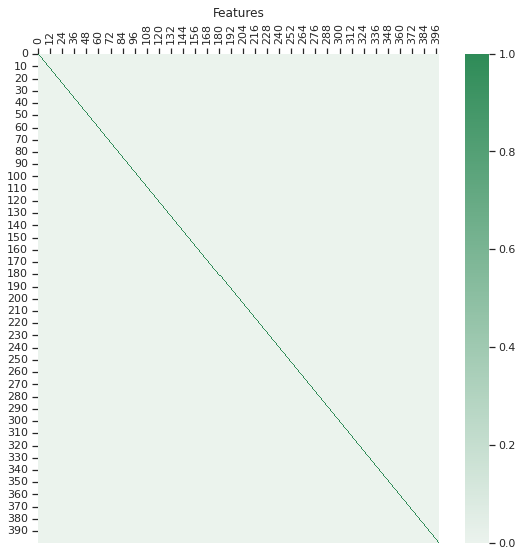

In [12]:
plotting.plot_heatmap(matrix=learner.features, title="Features")

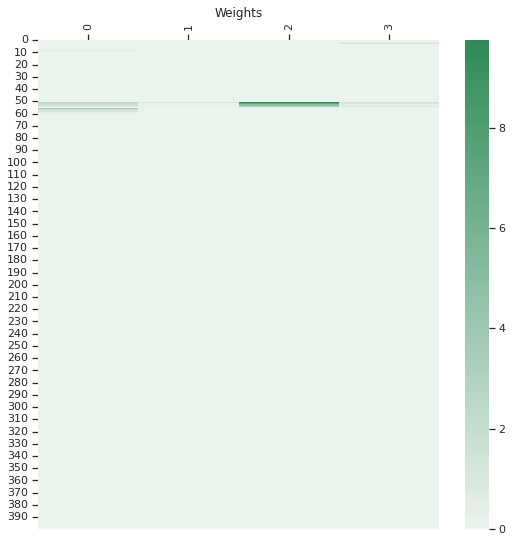

In [13]:
plotting.plot_heatmap(matrix=learner.weights, title="Weights")

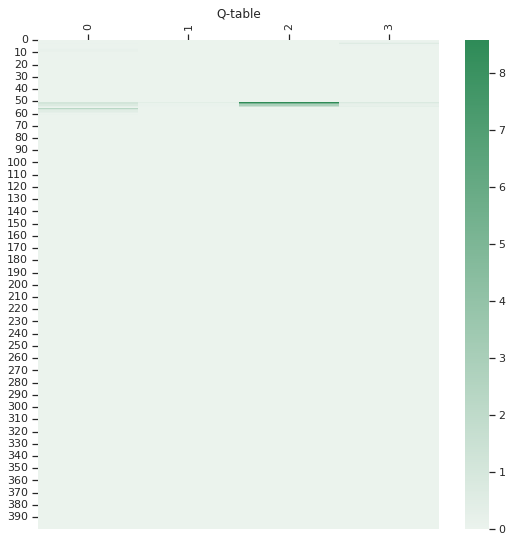

In [14]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

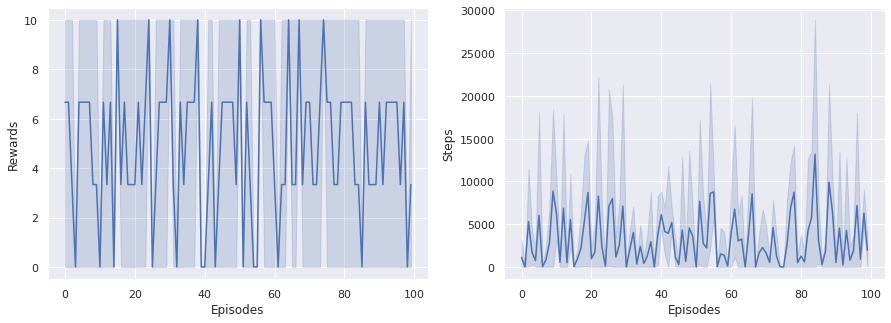

In [15]:
plotting.plot_steps_and_rewards(res)

In [ ]:
# plotting.plot_q_values_map(qtable, env.rows, env.cols)

In [ ]:
# plotting.plot_rotated_q_values_map(qtable, env.rows, env.cols)